In [7]:
# import dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Climate Analysis

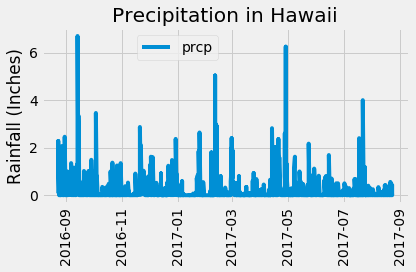

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

recent_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in recent_date:
    most_recent_date = date.date

most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")


# Calculate the date 1 year ago from today

one_year_ago = most_recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

recent_prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(recent_prcp_data).dropna()

# Sort the dataframe by date

df['date'] = pd.to_datetime(df['date'])


# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(df['date'], df['prcp'])
plt.title("Precipitation in Hawaii")
#plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(bbox_to_anchor=(0.5, 1.00))

# Rotate the xticks for the dates
plt.xticks(rotation='90')

plt.tight_layout()
plt.show()
#fig = plt.figure()
#plt.savefig("Images/Precipitation.png")

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# How many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [22]:
# What are the most active stations?
# List the stations and the counts in descending order.
station=pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                                  group_by(Measurement.station).\
                                  order_by('count DESC').all(),columns=["Station","No. of Measurements"])
station

,Station,No. of Measurements
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station, 
                                    func.count(Measurement.station).label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
                                    

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

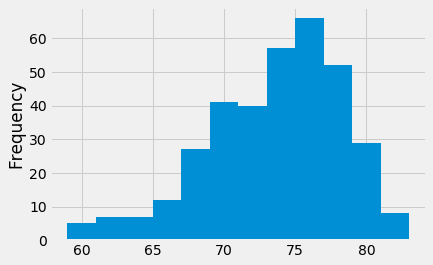

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active_station).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in most_active_tobs]


plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()
#plt.savefig("Images/Station-Histogram.png")

In [33]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-01-07', '2017-01-17'))

[(60.0, 69.33333333333333, 81.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-01-07', '2017-01-17')
temps

[(60.0, 69.33333333333333, 81.0)]

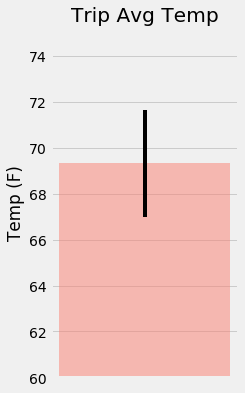

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='salmon', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [36]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by('rainfall DESC').all()
rainfall('2017-01-07', '2017-01-17')

[('USC00513117', 0.06, 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.0, 21.5213, -157.8374, 7.0),
 ('USC00516128', 0.0, 21.3331, -157.8025, 152.4),
 ('USC00519281', 0.0, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 21.33556, -157.71139, 19.5),
 ('USC00517948', None, 21.3934, -157.9751, 11.9)]